# 4. Evaluation Metrice for Classification
In the previous session we trainted a model for predicting churn. How do we know if it's good? 

## 4.1 Evaluation metrics: session overview
* Dataset: https//www.kaggle.com/blastchar/telco-customer-churn
* https:://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-03-churn-prediction/WA_Fn-UseC_-Telco-Customer-Churn.csv
Metric - function that compares the predictions with the actual values and outputs a single number that tells how good the predictions are

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression

In [3]:
data_url = 'https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-03-churn-prediction/WA_Fn-UseC_-Telco-Customer-Churn.csv'

In [4]:
import os
filename = 'data-week-4.csv'
if not os.path.exists(filename):
    os.system(f'wget {data_url} -O {filename}')
    print(f"Le fichier {filename} a été téléchargé avec succès.")
else:
    # Si le fichier existe déjà, imprimez un message
    print(f"Le fichier {filename} existe déjà.")

Le fichier data-week-4.csv existe déjà.


In [5]:
df = pd.read_csv(filename)
df.columns = df.columns.str.lower().str.replace(' ', '_') # edit columns names
categorical_columns = list(df.dtypes[df.dtypes == 'object'].index)
for c in categorical_columns:
    df[c] = df[c].str.lower().str.replace(' ', '_') # edit content of column

In [6]:
df['totalcharges'] = pd.to_numeric(df['totalcharges'], errors='coerce')
df.totalcharges = df.totalcharges.fillna(0)
df.churn = (df.churn == 'yes').astype(int)

In [7]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

df_train.reset_index(drop=True, inplace=True)
df_val.reset_index(drop=True, inplace=True)
df_test.reset_index(drop=True, inplace=True)

y_train = df_train.churn.values
y_val = df_val.churn.values
y_test = df_test.churn.values

df_train.drop('churn', axis=1, inplace=True)
df_val.drop('churn', axis=1, inplace=True)
df_test.drop('churn', axis=1, inplace=True)

In [8]:
numerical = ['tenure', 'monthlycharges', 'totalcharges']
categorical = ['customerid', 'gender', 'seniorcitizen', 'partner', 'dependents', 'phoneservice', 'multiplelines', 'internetservice',
       'onlinesecurity', 'onlinebackup', 'deviceprotection', 'techsupport',
       'streamingtv', 'streamingmovies', 'contract', 'paperlessbilling',
       'paymentmethod']

In [9]:
dv = DictVectorizer(sparse=False)
train_dicts = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dicts)
model = LogisticRegression()
model.fit(X_train, y_train)

/home/wm18vw/.conda/envs/machineLearning/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [10]:
val_dicts = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dicts)

y_pred = model.predict_proba(X_val)[:,1] # soft prediction
churn_decision = (y_pred >= 0.5)
(y_val == churn_decision).mean()

0.7991483321504613

## 4.2 Accuracy and dummy model

In [11]:
len(y_val)

1409

In [12]:
(y_val == churn_decision).sum()

1126

In [13]:
1125/1409

0.7984386089425124

In [14]:
from sklearn.metrics import accuracy_score

In [15]:
accuracy_score(y_val, y_pred >= 0.5)

0.7991483321504613

Accuracy $= \frac{1125}{1409} \approx 80\%$

In [16]:
thresholds = np.linspace(0,1,21)
scores = []

for t in thresholds:
    #churn_decision = (y_pred >= t)
    #score = (y_val == churn_decision).mean()
    score = accuracy_score(y_val, y_pred >= t)
    print('%.2f %.3f' % (t, score))
    scores.append(score)

0.00 0.274
0.05 0.513
0.10 0.595
0.15 0.666
0.20 0.708
0.25 0.735
0.30 0.756
0.35 0.769
0.40 0.783
0.45 0.796
0.50 0.799
0.55 0.803
0.60 0.795
0.65 0.786
0.70 0.763
0.75 0.745
0.80 0.734
0.85 0.726
0.90 0.726
0.95 0.726
1.00 0.726


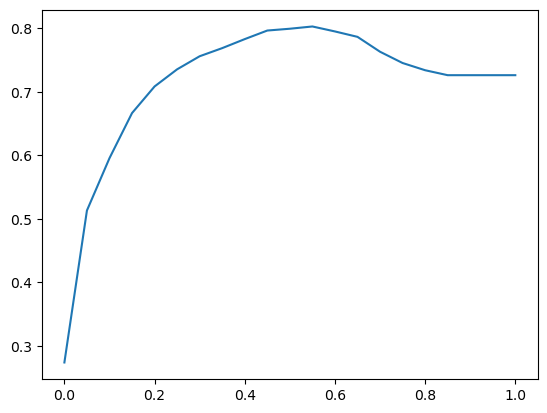

In [17]:
plt.plot(thresholds, scores)

In [18]:
from collections import Counter

In [19]:
Counter(y_pred >=1.0)

Counter({False: 1409})

In [20]:
1 - y_val.mean()

0.7260468417317246

## 4.3 Confusion table
* Different types of errors correct decisions
* Arranging therm in a table

In [21]:
actual_positive = (y_val == 1)
actual_negative = (y_val == 0)

In [22]:
actual_positive

array([False, False, False, ..., False,  True,  True])

In [23]:
t = 0.5
predict_positive = (y_pred >= t)
predict_negative = (y_pred < t)

In [24]:
predict_positive[:5]

array([False, False, False,  True, False])

In [25]:
actual_positive[:5]

array([False, False, False,  True, False])

In [26]:
tp = (predict_positive & actual_positive).sum() #true positive
tn = (predict_negative & actual_negative).sum() #true positive

In [27]:
fp = (predict_positive & actual_negative).sum()
fn = (predict_negative & actual_positive).sum()

In [28]:
fp, fn

(107, 176)

In [29]:
confusion_matrix = np.array([
    [tn, fp],
    [fn, tp]])
confusion_matrix

array([[916, 107],
       [176, 210]])

In [30]:
(confusion_matrix / confusion_matrix.sum()).round(2) # % de l'accuracy

array([[0.65, 0.08],
       [0.12, 0.15]])

Accuracy $= 0.65 + 0.15 = 0.8 \rightarrow 80\%$

## 4.4 Precision and Recall

In [31]:
(tp + tn) / (tp + tn + fp + fn)

0.7991483321504613

In [32]:
p = tp / (tp +fp)
p

0.6624605678233438

Precision $= 67\%$
Erreur: $33\%$

Recall = Fraction of correctly identified positive examples

In [33]:
r = tp / (tp + fn)
r

0.5440414507772021

## 4.5 ROC Curves
ROC stands for Receiver Operating Characteristics
This is a way of describing the performance of a binary classification model
### TPR and FPR

In [34]:
# True Positive Ratio. It's the same as Recall
tpr = tp / (tp + fn)
tpr

0.5440414507772021

In [35]:
# False Positive Ratio
fpr = fp / (fp + tn)
fpr

0.10459433040078202

In [36]:
scores = []

thresholds = np.linspace(0,1,101)
for t in thresholds:
    actual_positive = (y_val == 1)
    actual_negative = (y_val == 0)
    
    
    predict_positive = (y_pred >= t)
    predict_negative = (y_pred < t)
    
    tp = (predict_positive & actual_positive).sum() #true positive
    tn = (predict_negative & actual_negative).sum() #true positive
    
    fp = (predict_positive & actual_negative).sum()
    fn = (predict_negative & actual_positive).sum()
    
    scores.append((t, tp, fp, fn, tn))
    

In [37]:
columns = ['threshold', 'tp', 'fp', 'fn', 'tn']
df_scores = pd.DataFrame(scores, columns=columns)

In [38]:
df_scores[::10]

,threshold,tp,fp,fn,tn
0,0.0,386,1023,0,0
10,0.1,366,550,20,473
20,0.2,334,359,52,664
30,0.3,283,241,103,782
40,0.4,250,170,136,853
50,0.5,210,107,176,916
60,0.6,151,54,235,969
70,0.7,76,24,310,999
80,0.8,12,1,374,1022
90,0.9,0,0,386,1023


In [39]:
df_scores['tpr'] = df_scores.tp / (df_scores.tp + df_scores.fn)
df_scores['fpr'] = df_scores.fp / (df_scores.fp + df_scores.tn)
df_scores[::10]

,threshold,tp,fp,fn,tn,tpr,fpr
0,0.0,386,1023,0,0,1.000000,1.000000
10,0.1,366,550,20,473,0.948187,0.537634
20,0.2,334,359,52,664,0.865285,0.350929
30,0.3,283,241,103,782,0.733161,0.235582
40,0.4,250,170,136,853,0.647668,0.166178
50,0.5,210,107,176,916,0.544041,0.104594
60,0.6,151,54,235,969,0.391192,0.052786
70,0.7,76,24,310,999,0.196891,0.023460
80,0.8,12,1,374,1022,0.031088,0.000978
90,0.9,0,0,386,1023,0.000000,0.000000


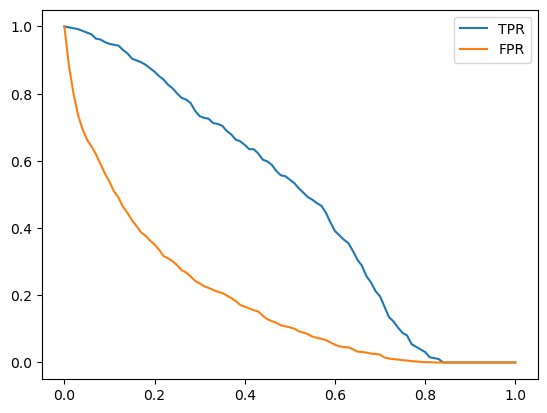

In [40]:
plt.plot(df_scores.threshold, df_scores['tpr'], label='TPR')
plt.plot(df_scores.threshold, df_scores['fpr'], label='FPR')
plt.legend()

### Random model

In [41]:
np.random.seed(1)
y_rand = np.random.uniform(0, 1, size=len(y_val))

In [42]:
((y_rand >= 0.5) == y_val).mean()

0.5017743080198722

In [43]:
def tpr_fpr_dataframe(y_val, y_pred):
    scores = []

    thresholds = np.linspace(0,1,101)
    for t in thresholds:
        actual_positive = (y_val == 1)
        actual_negative = (y_val == 0)
        
        
        predict_positive = (y_pred >= t)
        predict_negative = (y_pred < t)
        
        tp = (predict_positive & actual_positive).sum() #true positive
        tn = (predict_negative & actual_negative).sum() #true positive
        
        fp = (predict_positive & actual_negative).sum()
        fn = (predict_negative & actual_positive).sum()
        
        scores.append((t, tp, fp, fn, tn))
        
    columns = ['threshold', 'tp', 'fp', 'fn', 'tn']
    df_scores = pd.DataFrame(scores, columns=columns)
    
    df_scores['tpr'] = df_scores.tp / (df_scores.tp + df_scores.fn)
    df_scores['fpr'] = df_scores.fp / (df_scores.fp + df_scores.tn)
    
    return df_scores

In [44]:
df_rand = tpr_fpr_dataframe(y_val, y_rand)

In [45]:
df_rand[::10]

,threshold,tp,fp,fn,tn,tpr,fpr
0,0.0,386,1023,0,0,1.000000,1.000000
10,0.1,347,923,39,100,0.898964,0.902248
20,0.2,307,822,79,201,0.795337,0.803519
30,0.3,276,724,110,299,0.715026,0.707722
40,0.4,237,624,149,399,0.613990,0.609971
50,0.5,202,518,184,505,0.523316,0.506354
60,0.6,161,409,225,614,0.417098,0.399804
70,0.7,121,302,265,721,0.313472,0.295210
80,0.8,78,206,308,817,0.202073,0.201369
90,0.9,40,101,346,922,0.103627,0.098729


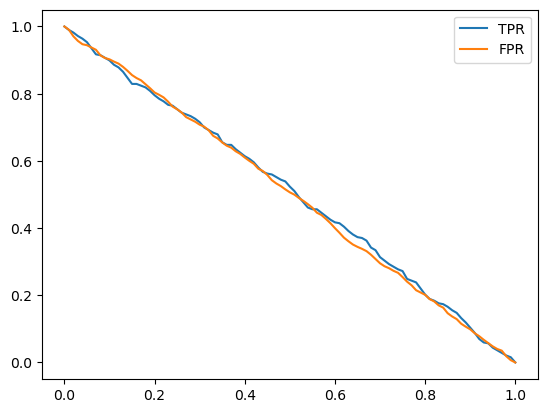

In [46]:
plt.plot(df_rand.threshold, df_rand['tpr'], label='TPR')
plt.plot(df_rand.threshold, df_rand['fpr'], label='FPR')
plt.legend()

### Ideal model

In [47]:
num_neg = (y_val == 0).sum()
num_pos = (y_val == 1).sum()
num_neg, num_pos

(1023, 386)

In [48]:
y_ideal = np.repeat([0,1], [num_neg, num_pos])
y_ideal[::100]#affiche les valeurs par pas de 100 (100, 200,..,1400)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1])

In [49]:
y_ideal_pred = np.linspace(0,1,len(y_val))

In [50]:
1 - y_val.mean()

0.7260468417317246

In [51]:
((y_ideal_pred >= 0.726) == y_ideal).mean()

1.0

In [52]:
df_ideal = tpr_fpr_dataframe(y_ideal, y_ideal_pred)

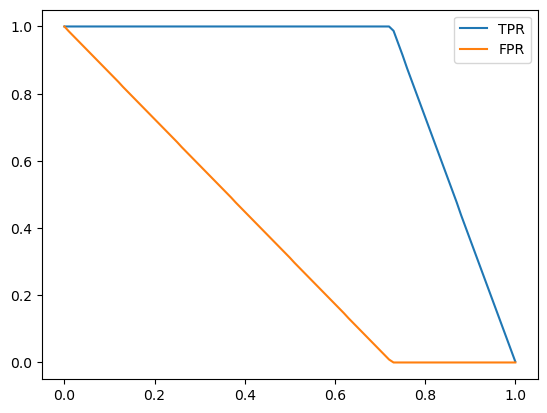

In [53]:
df_ideal

plt.plot(df_ideal.threshold,df_ideal['tpr'], label='TPR')
plt.plot(df_ideal.threshold, df_ideal['fpr'], label="FPR")
plt.legend()

On voit que le threshold est a 0.726

### Putting everything together

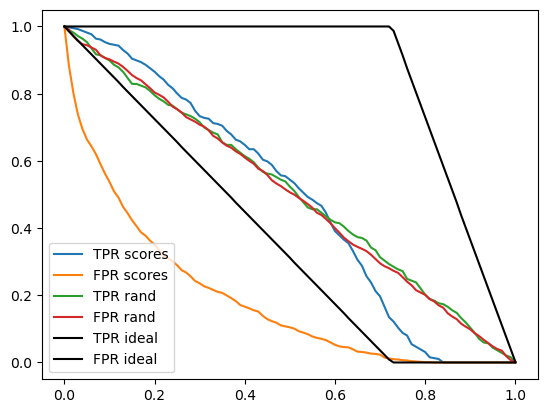

In [54]:
plt.plot(df_scores.threshold,df_scores['tpr'], label='TPR scores')
plt.plot(df_scores.threshold, df_scores['fpr'], label="FPR scores")

plt.plot(df_rand.threshold,df_rand['tpr'], label='TPR rand')
plt.plot(df_rand.threshold, df_rand['fpr'], label="FPR rand")

plt.plot(df_ideal.threshold,df_ideal['tpr'], label='TPR ideal', color='black')
plt.plot(df_ideal.threshold, df_ideal['fpr'], label="FPR ideal", color='black')
plt.legend()

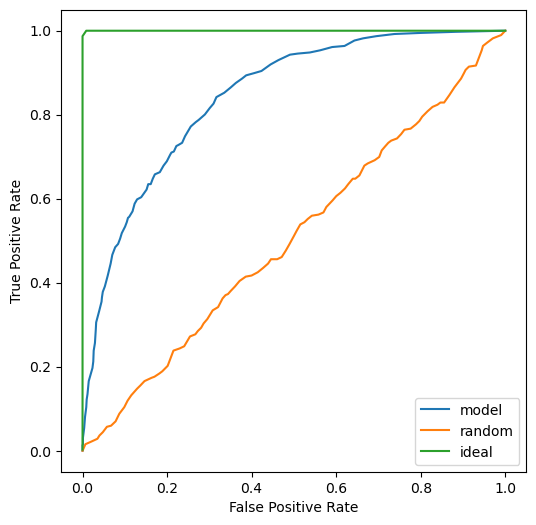

In [55]:
plt.figure(figsize=(6,6))
plt.plot(df_scores.fpr, df_scores.tpr, label='model')
plt.plot(df_rand.fpr, df_rand.tpr, label='random')
plt.plot(df_ideal.fpr, df_ideal.tpr, label='ideal')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.legend()

La courbe du modèle doit idéalement être la plus éloignée possible de la random et donc le plus proche possible de l'ideal

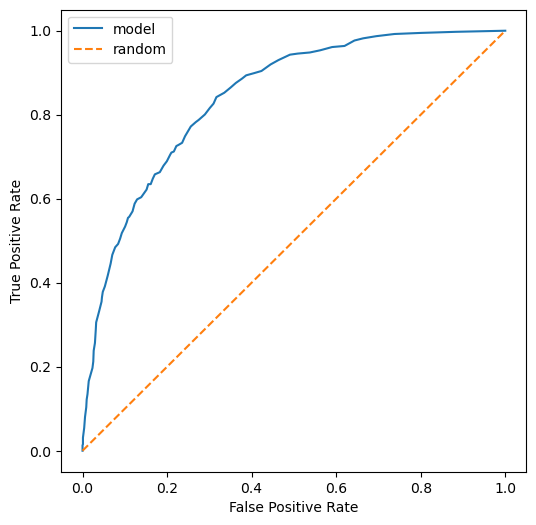

In [56]:
plt.figure(figsize=(6,6))
plt.plot(df_scores.fpr, df_scores.tpr, label='model')
plt.plot([0,1], [0,1], label='random', linestyle='--')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.legend()

https://www.youtube.com/watch?v=B5PATo1J6yw&list=PL3MmuxUbc_hIhxl5Ji8t4O6lPAOpHaCLR&index=45

In [57]:
from sklearn.metrics import roc_curve

In [58]:
fpr, tpr, thresholds = roc_curve(y_val, y_pred)

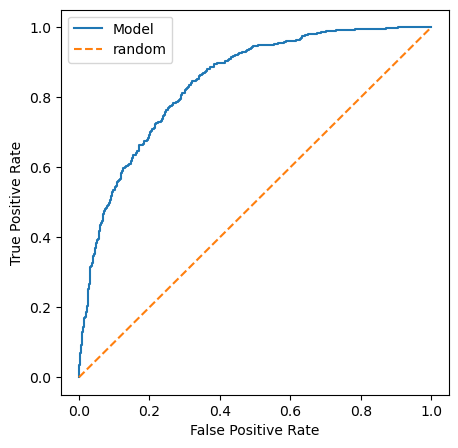

In [59]:
plt.figure(figsize=(5,5))

plt.plot(fpr, tpr, label='Model')
plt.plot([0,1], [0,1], label='random', linestyle='--')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.legend()

## 4.6 ROC AUC

* Area under the ROC curve - useful metric
* Interpretation of AUC
Le but est de mesurer l'air du graphique (1.0,1.0). Plus l'air sous la courbe est proche de 1.0² plus le modèle est bon. La droite correspond à 0.5. 0.6 c'est mauvais sous 0.5 c'est anormal.

In [60]:
from sklearn.metrics import auc

In [61]:
auc(x=fpr, y=tpr)

0.8423563733608861

In [62]:
auc(x=df_scores.fpr, y=df_scores.tpr) #with fpr and tpr that we computed manually

0.8422601411068735

Pretty close but fpr & tpr calculated by Sklearn is more accurate. Because we have evaluated the model in 101 threshold. We must use more threshold

In [63]:
auc(x=df_ideal.fpr, y=df_ideal.tpr)

0.9999430203759136

In [64]:
fpr, tpr, thresholds = roc_curve(y_true=y_val, y_score=y_pred)
auc(x=fpr, y=tpr)

0.8423563733608861

In [65]:
from sklearn.metrics import roc_auc_score

In [66]:
roc_auc_score(y_true=y_val, y_score=y_pred)

0.8423563733608861

On obtient les mêmes valeurs

In [67]:
neg = y_pred[y_val == 0]
pos = y_pred[y_val == 1]

In [68]:
import random

In [69]:
n = 100000
success = 0
for i in range(n):
    pos_ind = random.randint(0,len(pos)-1)
    neg_ind = random.randint(0,len(neg)-1)
    
    if pos[pos_ind] > neg[neg_ind]:
        success = success +1
success / n

0.84018

In [70]:
n = 50000

np.random.seed(1)
pos_ind = np.random.randint(0,len(pos), size=n)
neg_ind = np.random.randint(0,len(neg), size=n)
(pos[pos_ind] > neg[neg_ind]).mean()

0.84482

## 4.7 Cross-Validation
* Evaluating the same model on different subsets of data
* Getting the average prediction and the spread within predictions

In [71]:
def train(df_train, y_train, C=1.0):
    dicts = df_train[categorical + numerical].to_dict(orient='records')
    
    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)
    
    model = LogisticRegression(C=C, max_iter=1000)
    model.fit(X_train, y_train)
    return dv, model

In [72]:
dv, model = train(df_train=df_train, y_train=y_train, C=0.001) # smaller C specify stronger regularisation

In [73]:
def predict(df, dv, model):
    dicts = df[categorical + numerical].to_dict(orient='records')
    
    X = dv.transform(dicts)
    y_pred = model.predict_proba(X)[:,1]
    
    return y_pred

In [74]:
y_pred = predict(df_val, dv, model)

In [75]:
from sklearn.model_selection import KFold

In [76]:
kfold = KFold(n_splits=10, shuffle=True, random_state=1)

In [77]:
from tqdm.auto import tqdm

In [78]:
n_splits = 5

for C in tqdm([0.001, 0.01, 0.1, 0.5, 1.0, 5.0, 10.0]):
    kfold = KFold(n_splits=n_splits, shuffle=True, random_state=1)
    scores = []
    
    for train_idx, val_idx in kfold.split(df_full_train):
        df_train = df_full_train.iloc[train_idx]
        df_val = df_full_train.iloc[val_idx]
        
        y_train = df_train.churn.values
        y_val = df_val.churn.values
        
        dv, model = train(df_train, y_train, C=C)
        y_pred = predict(df_val, dv, model)
        
        auc = roc_auc_score(y_val, y_pred)
        scores.append(auc)
    print('C=%s %.3f +- %.3f' % (C, np.mean(scores), np.std(scores)))

  0%|          | 0/7 [00:00<?, ?it/s]

C=0.001 0.824 +- 0.010
C=0.01 0.840 +- 0.008
C=0.1 0.841 +- 0.008


/home/wm18vw/.conda/envs/machineLearning/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/wm18vw/.conda/envs/machineLearning/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/m

C=0.5 0.840 +- 0.005


/home/wm18vw/.conda/envs/machineLearning/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/wm18vw/.conda/envs/machineLearning/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/m

C=1.0 0.836 +- 0.004


/home/wm18vw/.conda/envs/machineLearning/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/wm18vw/.conda/envs/machineLearning/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/m

C=5.0 0.830 +- 0.004


/home/wm18vw/.conda/envs/machineLearning/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/wm18vw/.conda/envs/machineLearning/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/m

C=10.0 0.832 +- 0.012


/home/wm18vw/.conda/envs/machineLearning/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [79]:
scores

[0.8166393230290994,
 0.8453785094689446,
 0.8206261288380493,
 0.8333539841401805,
 0.84358037087007]

In [80]:
len(train_idx), len(val_idx)

(4508, 1126)

In [81]:
len(df_full_train)

5634

In [82]:
dv, model = train(df_full_train, df_full_train.churn.values, C=1.0)
y_pred = predict(df_test, dv, model)

auc = roc_auc_score(y_test, y_pred)
auc

0.8590071717204546

J'ai parcouru jusqu'au 4.8